# BinWaves example in Cantabria (Validation)

**In this notebook**: 
<br><br>
Here waves are reconstructed at the buoy location for comparison.
<br><br>
Steps:
- Buoy is loaded.
- Kp propagation coefficients and hindcast reconstruction is made at the buoy location.
- Comparison plots and statistics are shown.

In [2]:
import pandas as pd
import xarray as xr

# Load buoy data and kps

buoy_waves = pd.read_pickle("outputs/buoy_bulk_parameters.pkl")

kp_coeffs = (
    xr.open_dataset("outputs/kp_coeffs_buoy.nc")
    # 462805.45 4815333.56
)
kp_coeffs

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 25MB
Dimensions:   (case_num: 692, site: 1, freq: 38, dir: 120)
Coordinates:
  * case_num  (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
  * site      (site) int64 8B 2
  * freq      (freq) float64 304B 0.03 0.033 0.0363 0.0399 ... 0.8273 0.9096 1.0
  * dir       (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
    time      datetime64[ns] 8B ...
    lat       float64 8B ...
    lon       float64 8B ...
Data variables:
    efth      (case_num, site, freq, dir) float64 25MB ...

In [3]:
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("outputs/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("outputs/ERA5_offshore_spectra.nc"),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 692, time: 17520)> Size: 97MB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.46727731e-06, 2.74353282e-06, 0.00000000e+00, ...,
        2.51669694e-04, 3.10641143e-04, 3.62449514e-04],
       [1.91092512e-03, 1.89029968e-03, 1.94021481e-03, ...,
        5.75008078e-03, 6.67565053e-03, 7.74921899e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * case_num   (case_num) int64 6kB 0 2 5 6 8 9 10 ... 690 691 692 693 694 695
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00

In [27]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case,
    kp_coeffs=kp_coeffs,
)
# reconstructed_onshore_spectra.to_netcdf("outputs/reconstructed_spectra_san_buoy.nc")

# reconstructed_onshore_spectra = xr.open_dataset(
#     "outputs/reconstructed_spectra_san_buoy.nc"
# )
reconstructed_onshore_spectra

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34047 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41495
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:34047/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46007'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33273'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39109'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44827'


INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38091 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38091
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33560
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:44117 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44117
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33580
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:40413 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40413
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33572
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34577 name: 2
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34577
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33562
INFO:distributed.scheduler:Receive client co

<xarray.DataArray 'efth' (time: 17520, site: 1, freq: 38, dir: 120)> Size: 639MB
array([[[[7.30965114e-10, 3.97858583e-10, 2.65035444e-10, ...,
          1.14808762e-09, 1.20462538e-09, 1.01613526e-09],
         [3.81444208e-09, 1.16701944e-09, 7.17559209e-10, ...,
          6.37716053e-09, 8.12953149e-09, 7.60652950e-09],
         [1.87997629e-08, 3.52944628e-09, 1.00400854e-09, ...,
          2.93500230e-08, 3.38676208e-08, 3.10509821e-08],
         ...,
         [2.89952517e-06, 3.07108505e-06, 3.23261009e-06, ...,
          2.37198181e-06, 2.53836449e-06, 2.70818829e-06],
         [1.73789225e-06, 1.85915659e-06, 1.94130931e-06, ...,
          1.44994793e-06, 1.54589448e-06, 1.65674409e-06],
         [1.05928820e-06, 1.12549630e-06, 1.18221194e-06, ...,
          8.79557827e-07, 9.38057245e-07, 1.01916137e-06]]],


       [[[6.79799441e-10, 3.76822712e-10, 2.47942624e-10, ...,
          1.11564382e-09, 1.13305035e-09, 9.43058423e-10],
         [3.55398756e-09, 1.09900840e-09, 6.72881758e-10, ...,
          5.92733451e-09, 7.50144399e-09, 6.98409935e-09],
         [1.74995725e-08, 3.28449089e-09, 9.43050935e-10, ...,
...
          3.69384541e-06, 3.92500603e-06, 4.14023369e-06],
         [2.61295069e-06, 2.77067307e-06, 2.87720443e-06, ...,
          2.23422794e-06, 2.36691000e-06, 2.51762816e-06],
         [1.56863407e-06, 1.65467089e-06, 1.72929354e-06, ...,
          1.33645978e-06, 1.41758852e-06, 1.52351611e-06]]],


       [[[8.01647734e-07, 6.37575477e-08, 3.32159567e-10, ...,
          2.39316834e-06, 2.69102648e-06, 1.95169612e-06],
         [3.71063823e-06, 4.82214193e-07, 9.12522266e-10, ...,
          1.02562441e-05, 1.14332187e-05, 8.60313532e-06],
         [1.03533771e-05, 1.78995751e-06, 1.29094939e-09, ...,
          2.70717334e-05, 2.97077372e-05, 2.27225573e-05],
         ...,
         [4.43321407e-06, 4.64964325e-06, 4.85998685e-06, ...,
          3.79071677e-06, 4.02228600e-06, 4.23778924e-06],
         [2.67257421e-06, 2.82949405e-06, 2.93462942e-06, ...,
          2.29398200e-06, 2.42696717e-06, 2.57799663e-06],
         [1.60498123e-06, 1.69056650e-06, 1.76482121e-06, ...,
          1.37301367e-06, 1.45447852e-06, 1.56023278e-06]]]])
Coordinates:
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
  * site       (site) int64 8B 2
  * freq       (freq) float64 304B 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * dir        (dir) float64 960B 1.5 4.5 7.5 10.5 ... 349.5 352.5 355.5 358.5
    lat        float64 8B 0.0
    lon        float64 8B 0.0

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:511: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:511: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='Hs - Buoy [m]', ylabel='Hs - BinWaves [m]'>,
        <Axes: xlabel='Tp - Buoy [s]', ylabel='Tp - BinWaves [s]'>,
        <Axes: xlabel='Dir - Buoy [°]', ylabel='Dir - BinWaves [°]'>],
       dtype=object))

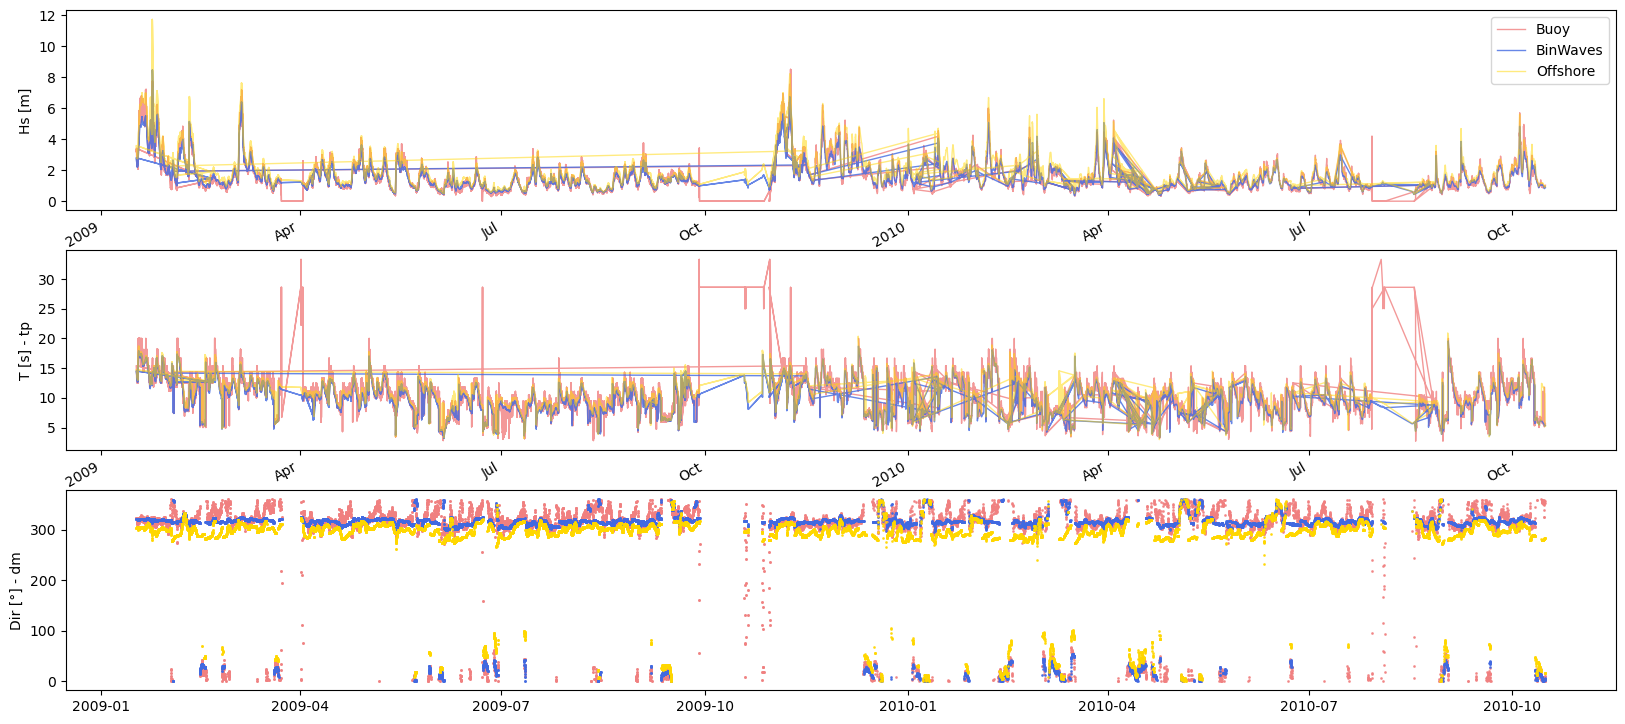

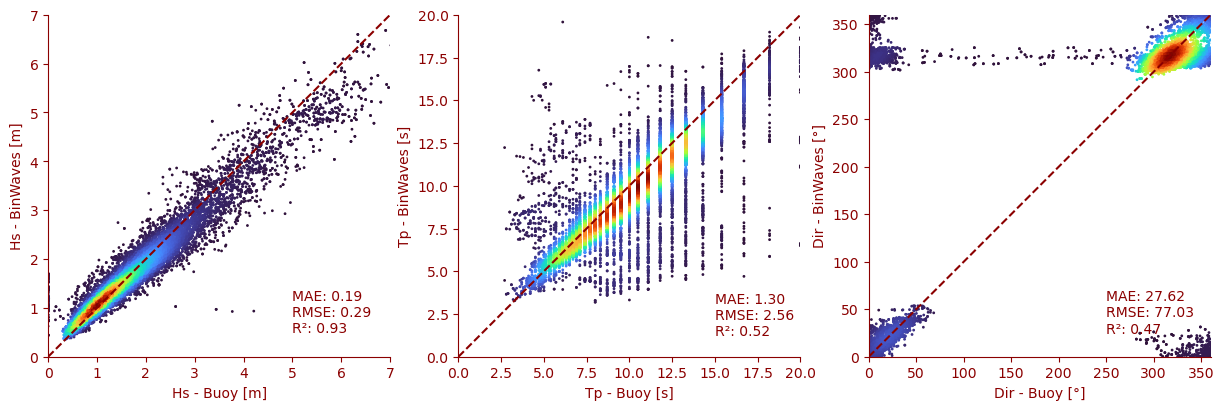

In [29]:
from utils.plotting import plot_wave_series

# Plot reconstructed bulk parameters vs buoy data

plot_wave_series(
    buoy_data=buoy_waves,
    binwaves_data=reconstructed_onshore_spectra.sel(
        site=2, time=buoy_waves.index, method="nearest"
    ).spec,
    offshore_data=offshore_spectra.sel(
        time=buoy_waves.index, method="nearest"
    ).spec,
    times=buoy_waves.index.values,
)